In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [ ]:
def read_electron_data(fname, nevts=1000):
    
    evt = -1
    xinc = 0.0
    yinc = 0.0
    front = True
    energy = 0.0
    
    # Open the file and read the specified number of events.
    l_evt, l_xinc, l_yinc, l_front, l_energy, l_row, l_col, l_counts = [], [], [], [], [], [], [], []
    evts_read = 0
    with open(fname) as f:
        
        # Iterate through all lines.
        for line in f:
            
            # Stop reading if we've read the specified number of events.
            if(evts_read > nevts):
                break
            
            # Get each number in the line, separated by spaces.
            vals = line.rstrip().split(" ")
            
            # Start a new event.
            if(vals[0] == "EV"):
                evt    = vals[1]
                xinc   = vals[2]
                yinc   = vals[3]
                front  = (vals[4] == 1)
                energy = vals[5]
                evts_read += 1
                
            # Add a row for the current event.
            else:
                l_evt.append(int(evt))
                l_xinc.append(float(xinc))
                l_yinc.append(float(yinc))
                l_front.append(front)
                l_energy.append(float(energy))
                l_row.append(int(vals[0]))
                l_col.append(int(vals[1]))
                l_counts.append(int(vals[2]))
    
    # Construct the DataFrame.
    evt_dict = {'event': l_evt, 'xinc': l_xinc, 'yinc': l_yinc, 'front': l_front, 
                'energy': l_energy, 'row': l_row, 'col': l_col, 'counts': l_counts}
    df = pd.DataFrame.from_dict(evt_dict)
    
    return df

In [ ]:
df = read_electron_data(datfile,nevts=100005)

In [ ]:
len(df.event.unique())

In [ ]:
df.to_pickle("EM_4um_back_10M_300keV.pkl")

### Examine individual events

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))

In [ ]:
max(df.xinc.values)

## Evaluate a dataset

In [ ]:
Nevts = 1000

In [ ]:
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

## Train a network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [5]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-5   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 203      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_80cells_noise_100k_202.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
dataset_train = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=10)
dataset_val   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=10)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 100000
Created dataset for events from 0 to -20000
Created dataset for events from -20000 to 20000


In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        tr.val(model, epoch, val_loader)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [7]:
torch.save(model.state_dict(), "{}/model_80cells_noise_100k_{}.pt".format(modeldir,epoch))

### Training and validation loss

Text(0.5, 1.0, 'Accuracy')

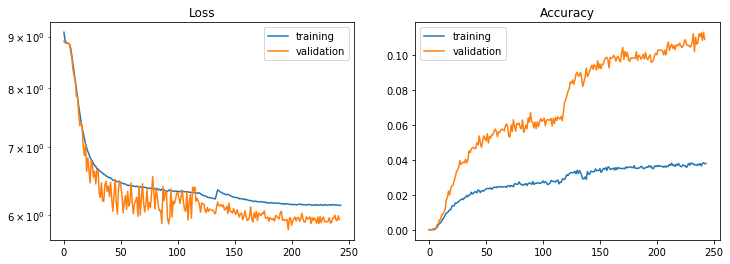

In [10]:
# Plot the training and validation losses.
tloss = np.loadtxt("train.txt")
vloss = np.loadtxt("val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [11]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
softmax = nn.Softmax(dim=1)
model.eval()

Created dataset for events from 0 to 100000


basicCNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=64, out_features=7056, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

In [78]:
SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE
ERR_PIXEL_SIZE = tr.PIXEL_SIZE*(2*dset.add_shift+1)/tr.ERR_SIZE

# Compute sigma_x and sigma_y of the given probability distribution
def compute_sigmas(prob_dist):
    
    sum_x, sum_xsq = 0, 0
    sum_y, sum_ysq = 0, 0
    for i in range(prob_dist.size):
        
        xi = int(i % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        yi = int(i / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        
        vi = prob_dist[np.unravel_index(i,prob_dist.shape)]
        sum_x   += xi*vi
        sum_xsq += xi**2*vi
        sum_y   += yi*vi
        sum_ysq += yi**2*vi
    
    # Compute mean and sigma.
    sum_tot = np.sum(prob_dist)
    mean_x = sum_x/sum_tot
    mean_y = sum_y/sum_tot
    sigma_x = (sum_xsq/sum_tot - mean_x**2)**0.5
    sigma_y = (sum_ysq/sum_tot - mean_y**2)**0.5
    
    return sigma_x, sigma_y

In [79]:
evts = np.arange(80000,85000)#100000)

l_evt, l_xtrue, l_ytrue, l_xpred, l_ypred, l_sigmax, l_sigmay = [], [], [], [], [], [], []
for evt in evts:
    
    evt_item = dset[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()
    output_score = model(data)
    
    # Compute the predicted pixel and (x,y) values.
    prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
    ipred = np.argmax(prob)
    xpred = int(ipred % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    ypred = int(ipred / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    #print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    # Compute the sigmas of the distribution.
    sigma_x, sigma_y = compute_sigmas(prob)
    
    # Fill the lists.
    l_evt.append(evt)
    l_xtrue.append(evt_lbl[0])
    l_ytrue.append(evt_lbl[1])
    l_xpred.append(xpred)
    l_ypred.append(ypred)
    l_sigmax.append(sigma_x)
    l_sigmay.append(sigma_y)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
        print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))

# Create the dataframe.
evt_dict = {'event': l_evt, 'x_true': l_xtrue, 'y_true': l_ytrue, 'x_pred': l_xpred, 
            'y_pred': l_ypred, 'sigma_x': l_sigmax, 'sigma_y': l_sigmay}
df = pd.DataFrame.from_dict(evt_dict)

# Create derived quantities.
df["sigma_r"] = (df.sigma_x**2 + df.sigma_y**2)**0.5
df["error_x"] = df.x_pred - df.x_true
df["error_y"] = df.y_pred - df.y_true
df["error_r"] = (df.error_x**2 + df.error_y**2)**0.5

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


Text(0, 0.5, 'Counts/bin')

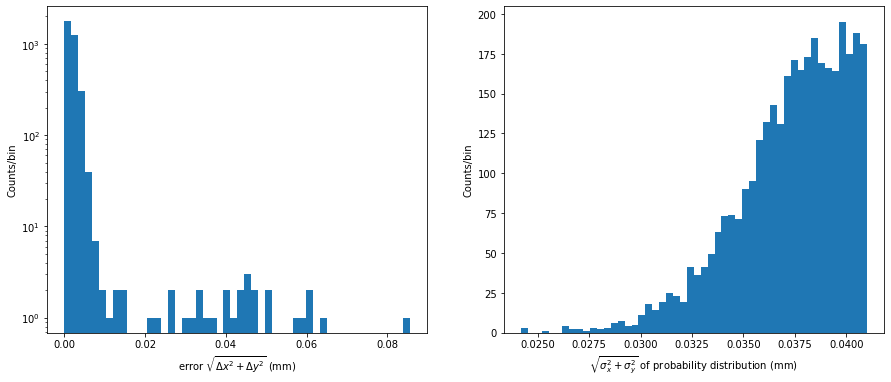

In [103]:
cut_sigma = 0.041

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r < cut_sigma].error_r,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r < cut_sigma].sigma_r,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

[SIGMA = 0.035]: EFF = 0.127, ERR = 0.0017182299924708773
[SIGMA = 0.035500000000000004]: EFF = 0.1548, ERR = 0.0017189331502403126
[SIGMA = 0.036000000000000004]: EFF = 0.1886, ERR = 0.0017376772821851932
[SIGMA = 0.036500000000000005]: EFF = 0.2304, ERR = 0.0017573557145865646
[SIGMA = 0.037000000000000005]: EFF = 0.2698, ERR = 0.0017695688560572683
[SIGMA = 0.037500000000000006]: EFF = 0.321, ERR = 0.001782963509619443
[SIGMA = 0.038000000000000006]: EFF = 0.368, ERR = 0.0018326716724564808
[SIGMA = 0.038500000000000006]: EFF = 0.4232, ERR = 0.001872358718512801
[SIGMA = 0.03900000000000001]: EFF = 0.473, ERR = 0.0019149633620321577
[SIGMA = 0.03950000000000001]: EFF = 0.5216, ERR = 0.0019502996538270773
[SIGMA = 0.04000000000000001]: EFF = 0.5778, ERR = 0.0020721369154320015
[SIGMA = 0.04050000000000001]: EFF = 0.6336, ERR = 0.002100536738745025
[SIGMA = 0.04100000000000001]: EFF = 0.685, ERR = 0.0022720660438158265
[SIGMA = 0.04150000000000001]: EFF = 0.7444, ERR = 0.0025566851329

Text(0, 0.5, 'Efficiency')

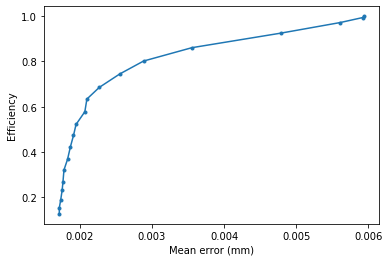

In [102]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.035,0.045,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
softmax = nn.Softmax(dim=1)
model.eval()

Computed index: 2409 for max added shift: 10


Text(0.5, 1.0, 'Incidence point within central pixel')

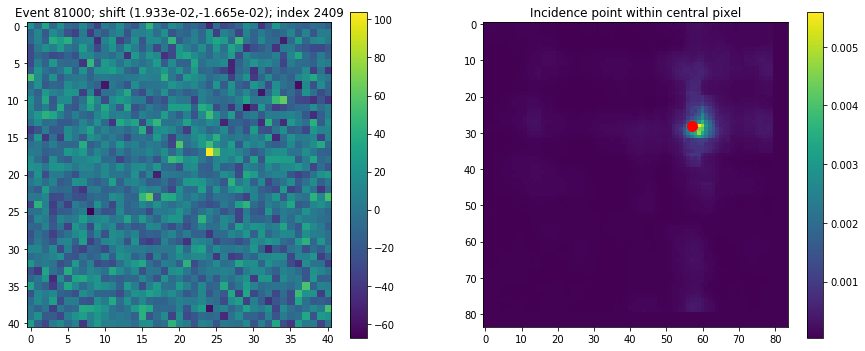

In [80]:
evt_plt = 81000
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE

xbin = int(tr.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,tr.ERR_SIZE-1)

ybin = int(tr.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,tr.ERR_SIZE-1)

print("Computed index:",(ybin*tr.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()

output_score = model(data)
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(122)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within central pixel")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")
